### Архитектура (в кратком виде):

```python
+-----------------+
| CCXT API        |
| (fetch OHLCV)   |
+--------+--------+
         |
         v
+--------+--------+
| Предобработка   |  <-- TA-Lib, TA, Pandas
+--------+--------+
         |
         v
+--------+--------+
| Технические     |  <-- RSI, MACD, BB, etc
| Индикаторы      |
+--------+--------+
         |
         v
+--------+--------+
| ML-модель       |  <-- Random Forest или Gradient Boosting, SVR
+--------+--------+
         |
         v
+--------+--------+
| Визуализация    |  <-- Визуальное сравнение моделей
+--------+--------+
         |
         v
+--------+--------+
| Веб-хуки        |  <-- Сигналы в Bybit
```


#### Про библиотеки

**ccxt (CryptoCurrency eXchange Trading Library)** — это библиотека для работы с различными криптовалютными биржами. Она предоставляет унифицированный интерфейс для доступа к API более чем 100 криптобирж, что позволяет разработчикам легко интегрировать функции торговли и получения данных о рынках.

**Основные функции:**
- Получение рыночных данных: Позволяет загружать данные о ценах, объемах и других рыночных показателях.
- Торговля: Поддерживает выполнение ордеров, получение информации о счетах и управление активами.
- Поддержка различных бирж: Обеспечивает совместимость с множеством популярных бирж, таких как Binance, Coinbase, Kraken и другие.
- Применение: Используется для создания торговых ботов, анализа рынка и автоматизации торговли.
-  ИНФОРМЦИЯ ПО БИБЛИОТЕКИ https://github.com/ccxt/ccxt/wiki/Manual

`pip install ta`

**ta (Technical Analysis Library)** — это библиотека для технического анализа, которая предоставляет удобный интерфейс для работы с индикаторами и сигналами. Она интегрируется с Pandas и позволяет легко добавлять индикаторы в DataFrame.
Основные функции:
- Индикаторы: Включает множество индикаторов, таких как SMA, EMA, RSI, MACD и другие.
- Простота использования: Позволяет легко добавлять индикаторы в DataFrame, что делает анализ данных более удобным.
- Гибкость: Поддерживает различные параметры для настройки индикаторов.
- Применение: Используется для анализа финансовых данных, создания торговых стратегий и визуализации результатов.

`pip install ta`

**talib (Technical Analysis Library)** — это библиотека для технического анализа финансовых данных. Она предоставляет множество индикаторов и функций для анализа временных рядов, таких как скользящие средние, RSI, MACD и многие другие.
**Основные функции:**
- Индикаторы: Включает более 150 различных индикаторов, которые можно использовать для анализа рыночных данных.
- Поддержка различных форматов данных: Может работать с массивами данных, полученными из различных источников, таких как Pandas DataFrame.
-Оптимизация производительности: Написана на C, что обеспечивает высокую производительность при вычислениях.
- Применение: Используется для анализа исторических данных, создания торговых стратегий и принятия решений на основе технического анализа

Как её себе поставить:
1. *(ТЕРМИНАЛ)* узнать версию питона: pip --version
1. Перейти сюды: https://github.com/cgohlke/talib-build/releases
1. Выбрать нужную версию и скачать.
1. *(ТЕРМИНАЛ)* Как выбрать? На основе версии питона и системы своей 32 или 64 бита: `python -c "import platform; print(platform.architecture())"`
1. *(ТЕРМИНАЛ)* Пример, у меня Python 3.10 и 64-битная система, и я скачал `ta_lib-0.6.3-cp310-cp310-win_amd64.whl`
1. *(ТЕРМИНАЛ)* Переходим в папку с загрузкой: `cd C:\Users\xndrf\Downloads `- это моё. 
1. *(ТЕРМИНАЛ)* Под свою версию питона ставим ``py -3.10 -m pip install ta_lib-0.6.3-cp310-cp310-win_amd64.whl``
1. *(ТЕРМИНАЛ)* Проверим установку: `py -3.10 -c "import talib; print(talib.get_functions())"`
1. И теперь пойдет у нас импорт `import talib`

### 0. Импорт библиотек

In [5]:
# Основа основ
import pandas as pd
import numpy as np

# Обучение
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.inspection import permutation_importance

# Графики
import matplotlib.pyplot as plt
import seaborn as sns

# Биржи
import ccxt
import time
import talib
import ta

### 1. Получение исторических данных с CCXT

In [6]:
def fetch_ohlcv_data(exchange_name, symbol, timeframe='1h', limit=1000):
    """Функция предназначена для получения исторических данных о ценах
    на криптовалюту в формате OHLCV с указанной криптобиржи

    Args:
        exchange_name (str): название криптобиржи (например, 'binance')
        symbol (str): Торговая пара (например, 'BTC/USDT').
        timeframe (str): Период времени для каждой свечи. Стандартно - 1h.
        limit (int): Максимальное количество свечей. Стандарт 1000.

    Returns:
        _type_: Датасет с собранными данными
    """    
    exchange_class = getattr(ccxt, exchange_name)()  #создаем экземпляр биржи
    exchange_class.load_markets() # загружаем рынки
    
    # Проверяем доступность торговой пары, есть или нет
    if symbol not in exchange_class.symbols:
        raise Exception(f"{symbol} not available on {exchange_name}")
    # Получаем OHLCV
    ohlcv = exchange_class.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
    # Всё это в датафрейм кидаем
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    # И временные метки лепим
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    return df


df = fetch_ohlcv_data('bitfinex', 'BTC/USDT', '1d', 500)
df

,timestamp,open,high,low,close,volume
0,2019-03-11,3870.1,3907.7,3850.0,3866.1,8.692549
1,2019-03-12,3866.1,3900.7,3821.9,3881.3,47.018426
2,2019-03-13,3885.9,3889.1,3846.1,3863.1,9.193549
3,2019-03-14,3873.6,3897.0,3800.9,3870.8,33.271493
4,2019-03-15,3892.0,3932.9,3886.6,3927.9,8.248969
...,...,...,...,...,...,...
495,2020-07-18,9151.7,9198.5,9124.6,9168.2,298.763918
496,2020-07-19,9169.0,9228.0,9105.7,9210.9,164.052004
497,2020-07-20,9214.9,9215.2,9132.2,9159.7,140.380323
498,2020-07-21,9157.7,9425.7,9155.8,9382.5,375.508933


In [24]:
def fetch_ohlcv_data(exchanges, symbols, timeframes, limit=1000):
    """
    Получает OHLCV данные с нескольких бирж для указанных торговых пар и временных интервалов.
    
    Parameters:
    - exchanges: list of str - список бирж
    - symbols: list of str - список торговых пар
    - timeframes: list of str - список временных интервалов
    - limit: int - количество свечей (по умолчанию 1000)
    
    Returns:
    - dict: словарь с данными в формате {биржа: {торговая_пара: {таймфрейм: DataFrame}}}
    """
    data = {}
    
    for exchange_id in exchanges:
        try:
            # Инициализация биржи
            exchange = getattr(ccxt, exchange_id)()
            exchange.load_markets()
            
            data[exchange_id] = {}
            
            for symbol in symbols:
                if symbol not in exchange.symbols:
                    print(f"Пара {symbol} не поддерживается на бирже {exchange_id}")
                    continue
                
                data[exchange_id][symbol] = {}
                
                for timeframe in timeframes:
                    try:
                        # Получение OHLCV данных
                        ohlcv = exchange.fetch_ohlcv(symbol, timeframe, limit=limit)
                        
                        # Преобразование в DataFrame
                        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
                        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
                        df.set_index('timestamp', inplace=True)
                        
                        data[exchange_id][symbol][timeframe] = df
                        print(f"Успешно получены данные: {exchange_id}, {symbol}, {timeframe}")
                        
                    except Exception as e:
                        print(f"Ошибка при получении данных {symbol} {timeframe} на {exchange_id}: {str(e)}")
                        data[exchange_id][symbol][timeframe] = None
        
        except Exception as e:
            print(f"Ошибка при инициализации биржи {exchange_id}: {str(e)}")
            data[exchange_id] = None
    
    return data

# Параметры для сбора данных
exchanges = ['binance', 'coinbase', 'kraken', 'bitfinex', 'huobi']
symbols = ['BTC/USDT', 'ETH/USDT', 'XRP/BTC', 'LTC/USD', 'ADA/USDT']
timeframes = ['1m', '5m', '15m', '30m', '1h', '4h', '1d']

# Получение данных
market_data = fetch_ohlcv_data(exchanges, symbols, timeframes)

#Пример доступа к данным:
binance_btc_1d = market_data['binance']['BTC/USDT']['1d']

binance_btc_1d

Успешно получены данные: binance, BTC/USDT, 1m
Успешно получены данные: binance, BTC/USDT, 5m
Успешно получены данные: binance, BTC/USDT, 15m
Успешно получены данные: binance, BTC/USDT, 30m
Успешно получены данные: binance, BTC/USDT, 1h
Успешно получены данные: binance, BTC/USDT, 4h
Успешно получены данные: binance, BTC/USDT, 1d
Успешно получены данные: binance, ETH/USDT, 1m
Успешно получены данные: binance, ETH/USDT, 5m
Успешно получены данные: binance, ETH/USDT, 15m
Успешно получены данные: binance, ETH/USDT, 30m
Успешно получены данные: binance, ETH/USDT, 1h
Успешно получены данные: binance, ETH/USDT, 4h
Успешно получены данные: binance, ETH/USDT, 1d
Успешно получены данные: binance, XRP/BTC, 1m
Успешно получены данные: binance, XRP/BTC, 5m
Успешно получены данные: binance, XRP/BTC, 15m
Успешно получены данные: binance, XRP/BTC, 30m
Успешно получены данные: binance, XRP/BTC, 1h
Успешно получены данные: binance, XRP/BTC, 4h
Успешно получены данные: binance, XRP/BTC, 1d
Пара LTC/USD н

,open,high,low,close,volume
timestamp,,,,,
2022-08-31,19813.03,20490.00,19797.94,20050.02,276946.60765
2022-09-01,20048.44,20208.37,19565.66,20131.46,245289.97263
2022-09-02,20132.64,20441.26,19755.29,19951.86,245986.60330
2022-09-03,19950.98,20055.93,19652.72,19831.90,146639.03204
2022-09-04,19832.45,20029.23,19583.10,20000.30,145588.77893
...,...,...,...,...,...
2025-05-22,109643.99,111980.00,109177.37,111696.21,31630.77313
2025-05-23,111696.22,111800.00,106800.00,107318.30,31737.72309
2025-05-24,107318.30,109506.03,106875.41,107761.91,16782.53129


<div class='alert alert-warning'>


- <span style="color:#000000">**Криптобиржи**</span> - <span style="color:#02020A">['binance', 'coinbase', 'kraken', 'bitfinex, 'huobi']</span>.

    Список криптобирж - `print(ccxt.exchanges)` или https://github.com/ccxt/ccxt/wiki/Exchange-Markets

- <span style="color:#000000">**Торговые пары**</span> - <span style="color:#02020A">['BTC/USDT', 'ETH/USDT', 'XRP/BTC', 'LTC/USD, 'ADA/USDT']</span>.
- <span style="color:#000000">**Временные интервалы**</span> - <span style="color:#02020A">['1m', '5m', '15m', '30m, '1h', '4h', '1d']</span>.
- <span style="color:#000000">**Количество свечей**</span> - <span style="color:#02020A">['100', '500', '1000', 'bitfinex, 'huobi']</span>.

### 2. Расчёт технических индикаторов (с помощью библиотеки ta)

In [7]:
def add_technical_indicators(df):
    """Функция для добавления различных технических индикаторов в DF/

    Args:
        df: Датафрейм после сбора

    Returns:
        df : Датафрейм с индикатарами
    """    
    # Cохраним исходные данные нетронутыми.
    df = df.copy()

    # Трендовые индикаторы
    # Вычисляет 20-дневную простую скользящую среднюю на основе цен закрытия и по закрытию
    df['sma_20'] = ta.trend.SMAIndicator(close=df['close'], window=20).sma_indicator()
    df['ema_20'] = ta.trend.EMAIndicator(close=df['close'], window=20).ema_indicator()
    # Индикатор Ишимоку предоставляет информацию о поддержке и сопротивлении, а также о направлении тренда.
    ichimoku = ta.trend.IchimokuIndicator(high=df['high'], low=df['low'], window1=9, window2=26, window3=52)
    df['ichimoku_a'] = ichimoku.ichimoku_a()
    df['ichimoku_b'] = ichimoku.ichimoku_b()

    # Осцилляторы
    # Индикатор относительной силы, который измеряет скорость и изменение ценовых движений.
    # Значения выше 70 указывают на перекупленность, а ниже 30 — на перепроданность.
    df['rsi'] = ta.momentum.RSIIndicator(close=df['close'], window=14).rsi()
    # Индикатор, который показывает разницу между 12-дневной и 26-дневной экспоненциальными скользящими средними.
    df['macd'] = ta.trend.MACD(close=df['close']).macd_diff()
    # Индикатор, который сравнивает текущую цену закрытия с диапазоном цен за определенный период.
    df['stochastic'] = ta.momentum.StochasticOscillator(
        high=df['high'],
        low=df['low'],
        close=df['close'],
        window=14,
        smooth_window=3
    ).stoch()

    # # Объёмные индикаторы
    # Индикатор, который использует объем для подтверждения тренда. Если цена растет, объем добавляется, если падает — вычитается.
    df['obv'] = ta.volume.OnBalanceVolumeIndicator(close=df['close'], volume=df['volume']).on_balance_volume()
    
    
    # !ХЗ чо делать, ошибку выдает.. надо ли этот индикатор
    # Индикатор, который показывает среднюю цену актива с учетом объема торгов.
    # df['vwap'] = ta.volume.VolumeWeightedAveragePrice(
    #     high=df['high'],
    #     low=df['low'],
    #     close=df['close'],
    #     volume=df['volume'],
    #     window=14
    # ).vwap()

    # Волатильность
    # Полосы Боллинджера состоят из средней скользящей и двух стандартных отклонений, которые помогают определить уровни поддержки и сопротивления.
    bollinger = ta.volatility.BollingerBands(close=df['close'], window=20, window_dev=2)
    df['bb_bbm'] = bollinger.bollinger_mavg()
    df['bb_bbh'] = bollinger.bollinger_hband()
    df['bb_bbl'] = bollinger.bollinger_lband()
    
    # Индикатор, который измеряет волатильность актива, показывая средний диапазон цен за определенный период.
    df['atr'] = ta.volatility.AverageTrueRange(
        high=df['high'],
        low=df['low'],
        close=df['close'],
        window=14
    ).average_true_range()
    
    return df

# Применение к DataFrame df
df = add_technical_indicators(df)
df

,timestamp,open,high,low,close,volume,sma_20,ema_20,ichimoku_a,ichimoku_b,rsi,macd,stochastic,obv,bb_bbm,bb_bbh,bb_bbl,atr
0,2019-03-11,3870.1,3907.7,3850.0,3866.1,8.692549,NaN,NaN,NaN,3878.85,NaN,NaN,NaN,8.692549,NaN,NaN,NaN,0.000000
1,2019-03-12,3866.1,3900.7,3821.9,3881.3,47.018426,NaN,NaN,NaN,3864.80,NaN,NaN,NaN,55.710975,NaN,NaN,NaN,0.000000
2,2019-03-13,3885.9,3889.1,3846.1,3863.1,9.193549,NaN,NaN,NaN,3864.80,NaN,NaN,NaN,46.517426,NaN,NaN,NaN,0.000000
3,2019-03-14,3873.6,3897.0,3800.9,3870.8,33.271493,NaN,NaN,NaN,3854.30,NaN,NaN,NaN,79.788919,NaN,NaN,NaN,0.000000
4,2019-03-15,3892.0,3932.9,3886.6,3927.9,8.248969,NaN,NaN,NaN,3866.90,NaN,NaN,NaN,88.037889,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2020-07-18,9151.7,9198.5,9124.6,9168.2,298.763918,9207.685,9229.942416,9235.750,9605.65,46.789239,-2.828665,45.891784,29131.475448,9207.685,9389.401199,9025.968801,200.407626
496,2020-07-19,9169.0,9228.0,9105.7,9210.9,164.052004,9208.870,9228.128852,9225.125,9605.65,48.634156,-0.113641,39.610544,29295.527452,9208.870,9390.345344,9027.394656,194.828510
497,2020-07-20,9214.9,9215.2,9132.2,9159.7,140.380323,9210.040,9221.611819,9173.850,9605.65,46.550030,-1.387874,27.451912,29155.147129,9210.040,9389.923522,9030.156478,186.840759
498,2020-07-21,9157.7,9425.7,9155.8,9382.5,375.508933,9217.670,9236.934503,9194.825,9605.65,55.488870,12.393504,80.360959,29530.656062,9217.670,9412.592601,9022.747399,192.773562


<div class='alert alert-warning'>


Также cуществует множество других технических индикаторов, которые можно добавить для более глубокого анализа рынка. 
Пока правда не ясно что с ними со всеми делать, но вот на всякий списочек:
- <span style="color:#000000">**Трендовые индикаторы**</span>.
1. **Hull Moving Average (HMA)**: Быстрая и гладкая скользящая средняя, которая уменьшает запаздывание.
1. **Arnaud Legoux Moving Average (ALMA)**: Скользящая средняя, которая учитывает весовые коэффициенты для более точного отображения тренда.
1. **Supertrend**: Индикатор, который помогает определить направление тренда и уровни поддержки/сопротивления.
- <span style="color:#000000">**Осцилляторы**</span>.
1. **Stochastic RSI (StochRSI)**: Осциллятор, который измеряет уровень перекупленности или перепроданности на основе RSI.
1. **Commodity Channel Index (CCI)**: Индикатор, который измеряет отклонение текущей цены от средней цены за определенный период.
1. **KDJ**: Осциллятор, который сочетает в себе элементы стохастического осциллятора и RSI.
- <span style="color:#000000">**Объёмные индикаторы**</span>.
1. **Chaikin Money Flow (CMF)**: Индикатор, который измеряет объемный поток денег, учитывая как цену, так и объем.
1. **Accumulation/Distribution Line (A/D)**: Индикатор, который показывает, как объем соотносится с ценой, чтобы определить, идет ли накопление или распределение актива</span>.
1. **Klinger Volume Oscillator (KVO)**: Индикатор, который использует объем для определения тренда.
- <span style="color:#000000">**Волатильность**</span>.
1. **Average True Range (ATR)**: Измеряет волатильность актива, показывая средний диапазон цен за определенный период.
1. **Bollinger Bands**: Полосы, которые показывают уровни поддержки и сопротивления на основе стандартного отклонения от скользящей средней.
1. **Keltner Channel**: Канал, который использует ATR для определения уровней поддержки и сопротивления.
- <span style="color:#000000">**Другие индикаторы**</span>.
1. **Elder Ray Index**: Индикатор, который показывает силу быков и медведей на рынке.
1. **Mass Index**: Индикатор, который помогает определить возможные развороты тренда.
1. **Donchian Channel**: Индикатор, который показывает максимумы и минимумы за определенный период, что помогает определить уровни поддержки и сопротивления.


Если необходимо доп, то вот функция:


```python
def add_technical_indicators(df):
    # Убедимся, что индикаторы не дублируются
    df = df.copy()

    # Трендовые индикаторы
    df['hma'] = ta.trend.HullMovingAverage(close=df['close'], window=14).hull_moving_average()
    df['alma'] = ta.trend.ALMAClose(close=df['close'], window=14).alma()

    # Осцилляторы
    df['stochrsi'] = ta.momentum.StochasticOscillator(
        close=df['close'],
        window=14,
        smooth_window=3
    ).stochrsi()

    df['cci'] = ta.trend.CCIIndicator(high=df['high'], low=df['low'], close=df['close'], window=20).cci()

    # Объёмные индикаторы
    df['cmf'] = ta.volume.ChaikinMoneyFlowIndicator(
        high=df['high'],
        low=df['low'],
        close=df['close'],
        volume=df['volume'],
        window=20
    ).chaikin_money_flow()

    # Волатильность
    df['atr'] = ta.volatility.AverageTrueRange(
        high=df['high'],
        low=df['low'],
        close=df['close'],
        window=14
    ).average_true_range()

    return df
```

### 3. Распознавание свечных паттернов (молот, звезда и пр.)

In [8]:
def add_candlestick_patterns(df):
    """Функция по добавлениб информации о различных свечных паттернах в df
    info - Свечные паттерны являются важным инструментом технического анализа, 
    так как они могут сигнализировать о возможных разворотах или продолжениях тренда. 

    Args:
        df (_type_): DF

    Returns:
        _type_: DF 
    """    
    
    # Извлекаем значения открывающих, высоких, низких и закрывающих цен из DataFrame и сохраняе в отдельные массивы. 
    # Это необходимо для передачи данных в функции TA-Lib, которые требуют массивы в качестве входных данных.
    open = df['open'].values
    high = df['high'].values
    low = df['low'].values
    close = df['close'].values
  
    df['hammer'] = talib.CDLHAMMER(open, high, low, close) # паттерн указывает на возможный разворот вверх
    df['shooting_star'] = talib.CDLSHOOTINGSTAR(open, high, low, close) # паттерн указывает на возможный разворот вниз
    df['engulfing'] = talib.CDLENGULFING(open, high, low, close) # паттерн указывает на сильный разворот
    
    return df

# Assuming df is your DataFrame with OHLC data
df = add_candlestick_patterns(df)

<div class='alert alert-info'>

Функция возвращает обновленный DataFrame, который теперь содержит дополнительные столбцы с информацией о свечных паттернах. Каждое значение в этих столбцах будет представлять собой целое число, где:

- **100:** Паттерн обнаружен (например, для молота или поглощения).

- **-100:** Паттерн обнаружен, но в обратном направлении (например, для падающей звезды).
- **0:** Паттерн не обнаружен.
- 
Используя эту функцию, трейдеры могут автоматизировать процесс обнаружения паттернов и принимать более обоснованные торговые решения.

In [9]:
df

,timestamp,open,high,low,close,volume,sma_20,ema_20,ichimoku_a,ichimoku_b,...,macd,stochastic,obv,bb_bbm,bb_bbh,bb_bbl,atr,hammer,shooting_star,engulfing
0,2019-03-11,3870.1,3907.7,3850.0,3866.1,8.692549,NaN,NaN,NaN,3878.85,...,NaN,NaN,8.692549,NaN,NaN,NaN,0.000000,0,0,0
1,2019-03-12,3866.1,3900.7,3821.9,3881.3,47.018426,NaN,NaN,NaN,3864.80,...,NaN,NaN,55.710975,NaN,NaN,NaN,0.000000,0,0,0
2,2019-03-13,3885.9,3889.1,3846.1,3863.1,9.193549,NaN,NaN,NaN,3864.80,...,NaN,NaN,46.517426,NaN,NaN,NaN,0.000000,0,0,-100
3,2019-03-14,3873.6,3897.0,3800.9,3870.8,33.271493,NaN,NaN,NaN,3854.30,...,NaN,NaN,79.788919,NaN,NaN,NaN,0.000000,0,0,0
4,2019-03-15,3892.0,3932.9,3886.6,3927.9,8.248969,NaN,NaN,NaN,3866.90,...,NaN,NaN,88.037889,NaN,NaN,NaN,0.000000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2020-07-18,9151.7,9198.5,9124.6,9168.2,298.763918,9207.685,9229.942416,9235.750,9605.65,...,-2.828665,45.891784,29131.475448,9207.685,9389.401199,9025.968801,200.407626,0,0,0
496,2020-07-19,9169.0,9228.0,9105.7,9210.9,164.052004,9208.870,9228.128852,9225.125,9605.65,...,-0.113641,39.610544,29295.527452,9208.870,9390.345344,9027.394656,194.828510,0,0,0
497,2020-07-20,9214.9,9215.2,9132.2,9159.7,140.380323,9210.040,9221.611819,9173.850,9605.65,...,-1.387874,27.451912,29155.147129,9210.040,9389.923522,9030.156478,186.840759,0,0,-100
498,2020-07-21,9157.7,9425.7,9155.8,9382.5,375.508933,9217.670,9236.934503,9194.825,9605.65,...,12.393504,80.360959,29530.656062,9217.670,9412.592601,9022.747399,192.773562,0,0,100


### 4. Подготовка данных для ML

In [10]:
def prepare_ml_dataset_regression(df, future_bars=1):
    """Функция для подготовки набора данных для регрессии
    
    Args:
        df: DataFrame с данными
        future_bars: на сколько баров вперед предсказываем
        
    Returns:
        X: признаки
        y: целевая переменная (будущая цена)
    """
    df = df.dropna()
    
    # Если прибавляем доп индикаторы, то добавить сюды:
    features = [
        'open', 'high', 'low', 'close', 'volume',
        'sma_20', 'ema_20', 'ichimoku_a', 'ichimoku_b',
        'rsi', 'macd', 'stochastic', 'obv',
        'bb_bbm', 'bb_bbh', 'bb_bbl', 'atr',
        'hammer', 'shooting_star', 'engulfing'
    ]
    
    # Целевая переменная - будущая цена через future_bars баров
    y = df['close'].shift(-future_bars).dropna()
    X = df[features].iloc[:-future_bars]
    
    return X, y

In [15]:
y

33     5127.6
34     5041.4
35     5175.2
36     5208.3
37     5257.2
        ...  
494    9168.2
495    9210.9
496    9159.7
497    9382.5
498    9522.8
Name: close, Length: 466, dtype: float64

### 5. Обучение моделей ML 

In [11]:
# Подготовка данных для регрессии
X, y = prepare_ml_dataset_regression(df, future_bars=1)

# Разделение на train/test с учетом временных рядов
test_size = 0.2
split_idx = int(len(X) * (1 - test_size))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Нормализация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Инициализация моделей
models = {
    'Random Forest': RandomForestRegressor(n_estimators=200, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, random_state=42),
    'SVR': SVR(kernel='rbf', C=1.0, epsilon=0.1)
}

# Обучение и оценка моделей
for name, model in models.items():
    print(f"\n=== {name} ===")
    
    # Кросс-валидация
    tscv = TimeSeriesSplit(n_splits=5)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, 
                               cv=tscv, scoring='neg_mean_squared_error')
    print(f"CV RMSE: {np.sqrt(-cv_scores.mean()):.2f}")
    
    # Обучение модели
    model.fit(X_train_scaled, y_train)
    
    # Предсказание
    y_pred = model.predict(X_test_scaled)
    
    # Вычисление метрик
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")
    
    # Вывод важности признаков (для tree-based моделей)
    if hasattr(model, 'feature_importances_'):
        feature_importance = pd.Series(model.feature_importances_, index=X.columns)
        print("\nВажность признаков:")
        print(feature_importance.sort_values(ascending=False).head(10))


=== Random Forest ===
CV RMSE: 1297.25
MAE: 258.94
RMSE: 348.67
R²: 0.71

Важность признаков:
close         0.846559
low           0.062488
high          0.047760
open          0.011160
obv           0.004934
rsi           0.004337
bb_bbh        0.002550
macd          0.002547
stochastic    0.002510
atr           0.002487
dtype: float64

=== Gradient Boosting ===
CV RMSE: 1398.98
MAE: 239.50
RMSE: 327.29
R²: 0.75

Важность признаков:
close         0.849380
high          0.075536
low           0.034688
rsi           0.008715
volume        0.003910
obv           0.003712
ema_20        0.003619
stochastic    0.003478
open          0.003155
macd          0.003011
dtype: float64

=== SVR ===
CV RMSE: 2006.12
MAE: 844.32
RMSE: 903.27
R²: -0.92


<div class='alert alert-info'>

Краткие выводы:
- <span style="color:#000000">**Random Forest**</span>.

1. R² = 0.71 - хороший показатель, модель объясняет 71% дисперсии цены
1. RMSE = $348 - средняя ошибка предсказания
1. MAE = $258 - средняя абсолютная ошибка

- <span style="color:#000000">**Gradient Boosting**</span>.

1. R² = 0.75 - немного лучше чем у Random Forest
1. RMSE = $327 - лучший результат среди моделей
1. MAE = $239 - самая точная модель

- <span style="color:#000000">**SVR**</span>. - хуже некуда


**Важность признаков:**

- Цена закрытия (close) доминирует с важностью 84.6% - Не очень здорово..

- Остальные признаки практически не влияют на предсказание (<6% каждый)

<span style="color:#dc143c">**НАДО БЫ ИЗМЕНИТЬ ЦЕЛЕВУЮ ПЕРЕМЕННУЮ И ПРОРАБОТАТЬ НОВЫЕ МОДЕЛИ**</span>.

### 6. Визуализация

In [13]:
# Настройка стиля графиков
plt.rcParams['figure.figsize'] = [12, 6]

# 1. Визуализация распределения и важности признаков
def plot_feature_analysis(X, y):
    # График распределения целевой переменной
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(y, kde=True)
    plt.title('Распределение целевой переменной (цена)')
    
    # Корреляция признаков с целевой переменной
    plt.subplot(1, 2, 2)
    correlations = X.corrwith(y).sort_values(ascending=False)
    sns.barplot(x=correlations.values, y=correlations.index, hue=correlations.index, palette='viridis', legend=False)
    # sns.barplot(x=correlations.values, y=correlations.index, palette='viridis') - Иначе предупреждения вылетают. Выше строка решает вопрос
    plt.title('Корреляция признаков с целевой переменной')
    plt.tight_layout()
    plt.show()

# 2. Визуализация важности признаков
def plot_feature_importance(model, X, X_columns, y, model_name):
    plt.figure(figsize=(10, 6))
    
    if hasattr(model, 'feature_importances_'):
        # Для моделей с атрибутом feature_importances_
        importance = model.feature_importances_
        feat_importance = pd.Series(importance, index=X_columns)
        feat_importance.nlargest(15).plot(kind='barh')
    else:
        # Для моделей без feature_importances_ используем permutation importance
        result = permutation_importance(model, X, y, n_repeats=10, random_state=42)
        feat_importance = pd.Series(result.importances_mean, index=X_columns)
        feat_importance.nlargest(15).plot(kind='barh')
    
    plt.title(f'{model_name}: Важность признаков')
    plt.show()

# 3. Сравнение моделей и визуализация предсказаний
def compare_models(models, X_train, X_test, y_train, y_test, feature_names):
    metrics = []
    
    plt.figure(figsize=(14, 8))
    for i, (name, model) in enumerate(models.items()):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Вычисление метрик
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        metrics.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2})
        
        # Визуализация предсказаний
        plt.subplot(2, 2, i+1)
        plt.plot(y_test.values, label='Реальные значения', linewidth=2)
        plt.plot(y_pred, label='Предсказания', alpha=0.7)
        plt.title(f'{name}\nMAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}')
        plt.legend()
        
        # Важность признаков
        plot_feature_importance(model, X_train, feature_names, y_train, name)
    
    plt.tight_layout()
    plt.show()
    
    # Таблица сравнения метрик
    metrics_df = pd.DataFrame(metrics).set_index('Model')
    print("\nСравнение метрик моделей:")
    display(metrics_df.style.background_gradient(cmap='Blues'))
    
    # График сравнения метрик
    metrics_df.plot(kind='bar', subplots=True, layout=(1, 3), figsize=(18, 5))
    plt.tight_layout()
    plt.show()

# 4. Визуализация технических индикаторов
def plot_technical_indicators(df):
    plt.figure(figsize=(16, 12))
    
    # Цена и скользящие средние
    plt.subplot(3, 1, 1)
    plt.plot(df['close'], label='Цена закрытия', alpha=0.5)
    plt.plot(df['sma_20'], label='SMA 20', linestyle='--')
    plt.plot(df['ema_20'], label='EMA 20', linestyle='--')
    plt.title('Цена и скользящие средние')
    plt.legend()
    
    # Осцилляторы
    plt.subplot(3, 1, 2)
    plt.plot(df['rsi'], label='RSI', color='purple')
    plt.axhline(70, linestyle='--', color='red', alpha=0.3)
    plt.axhline(30, linestyle='--', color='green', alpha=0.3)
    plt.title('Осцилляторы (RSI)')
    plt.legend()
    
    # Полосы Боллинджера
    plt.subplot(3, 1, 3)
    plt.plot(df['close'], label='Цена закрытия', alpha=0.5)
    plt.plot(df['bb_bbm'], label='Средняя полоса', linestyle='--')
    plt.plot(df['bb_bbh'], label='Верхняя полоса', linestyle='--', color='green')
    plt.plot(df['bb_bbl'], label='Нижняя полоса', linestyle='--', color='red')
    plt.fill_between(df.index, df['bb_bbh'], df['bb_bbl'], color='grey', alpha=0.1)
    plt.title('Полосы Боллинджера')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

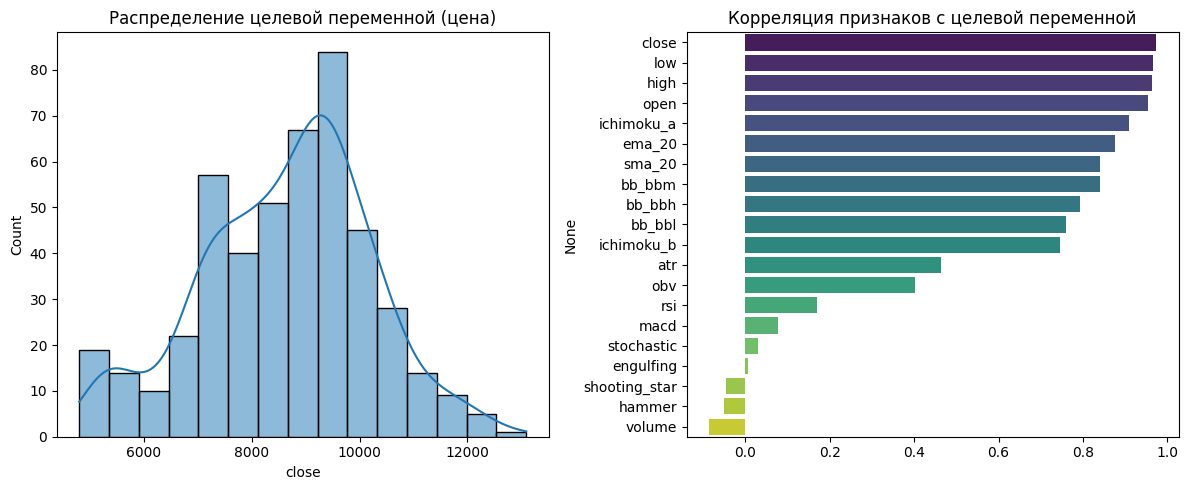

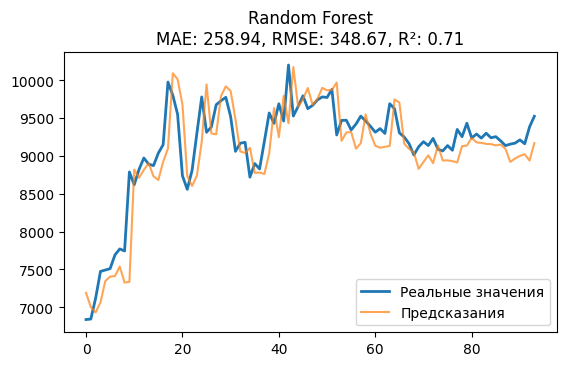

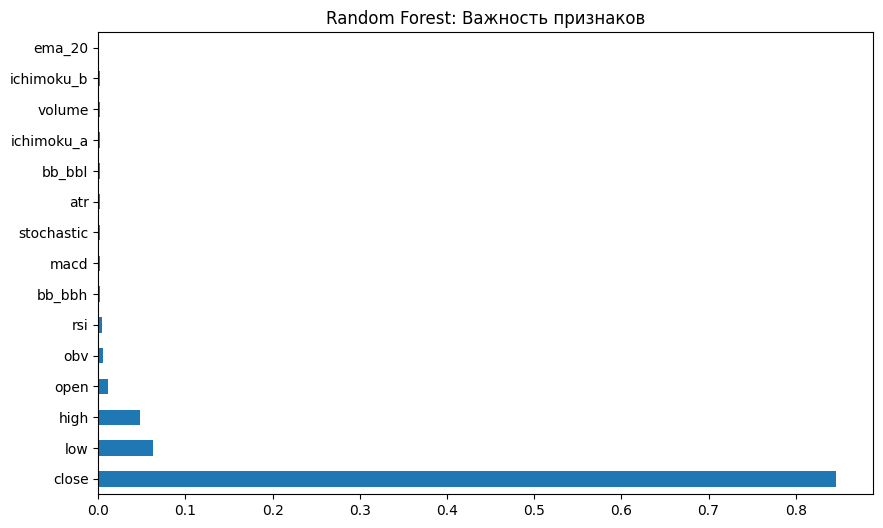

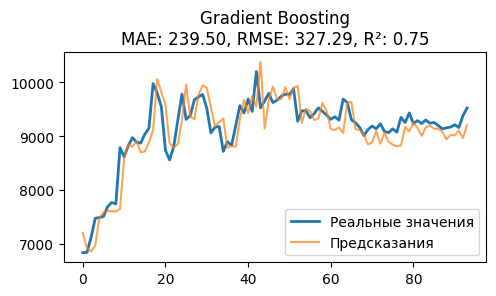

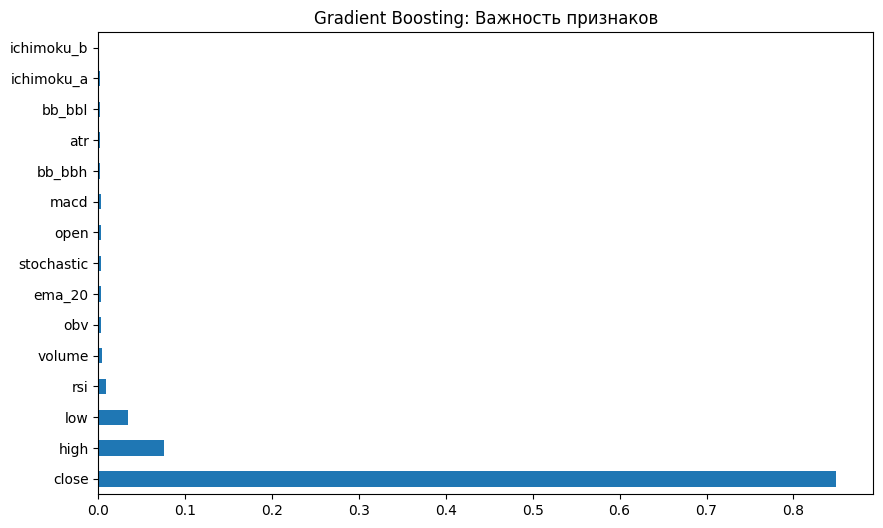

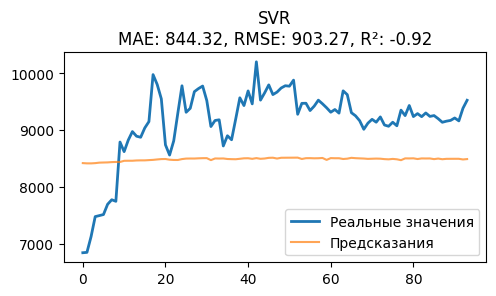

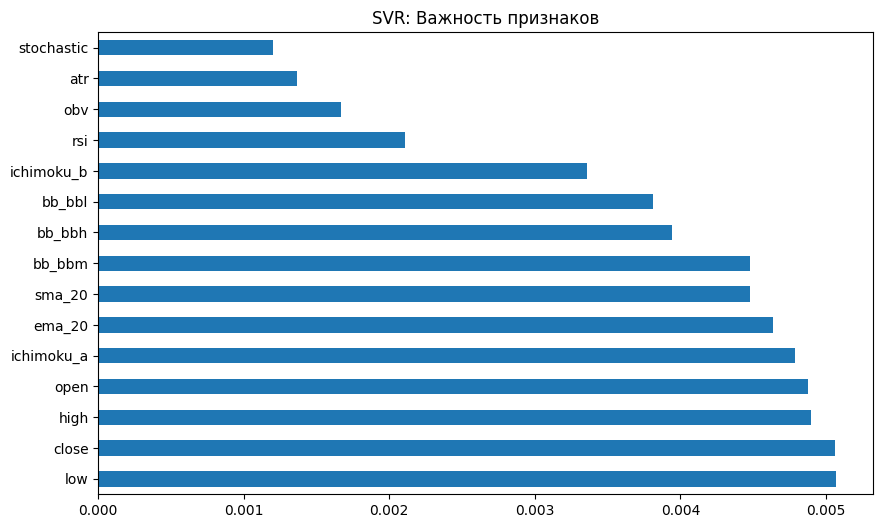

<Figure size 1200x600 with 0 Axes>


Сравнение метрик моделей:


,MAE,RMSE,R2
Model,,,
Random Forest,258.943266,348.671987,0.714450
Gradient Boosting,239.496037,327.287582,0.748402
SVR,844.318072,903.274174,-0.916406


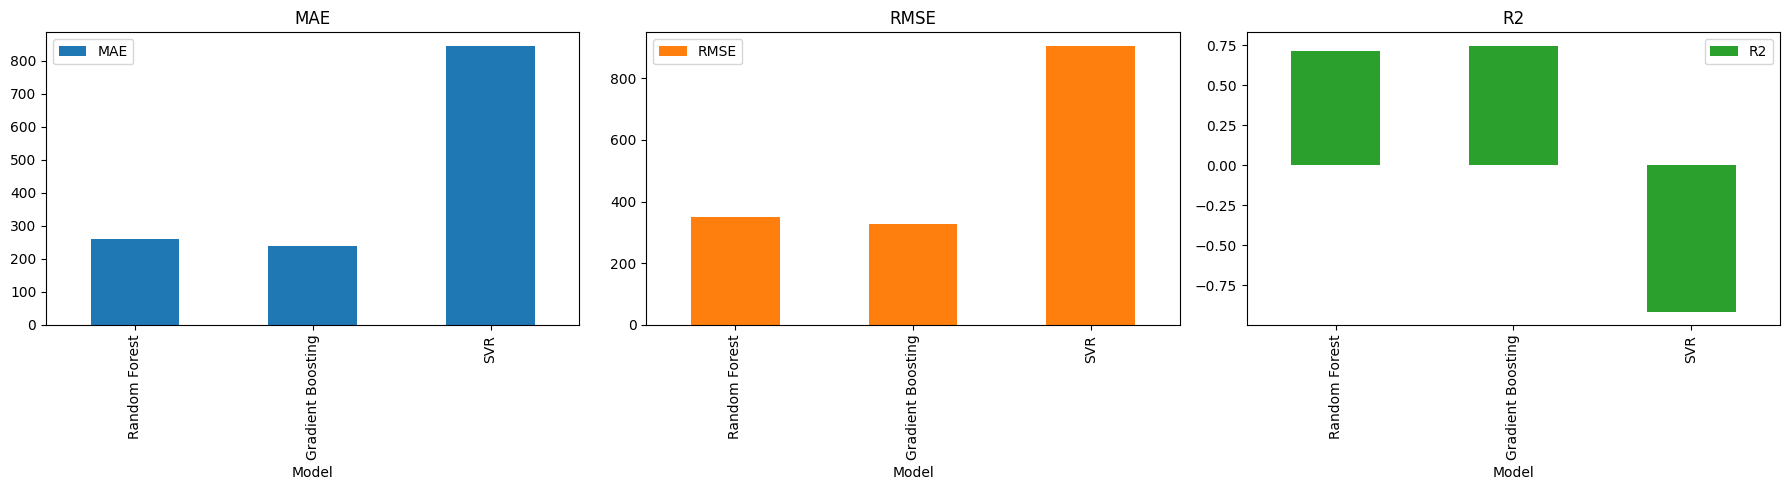

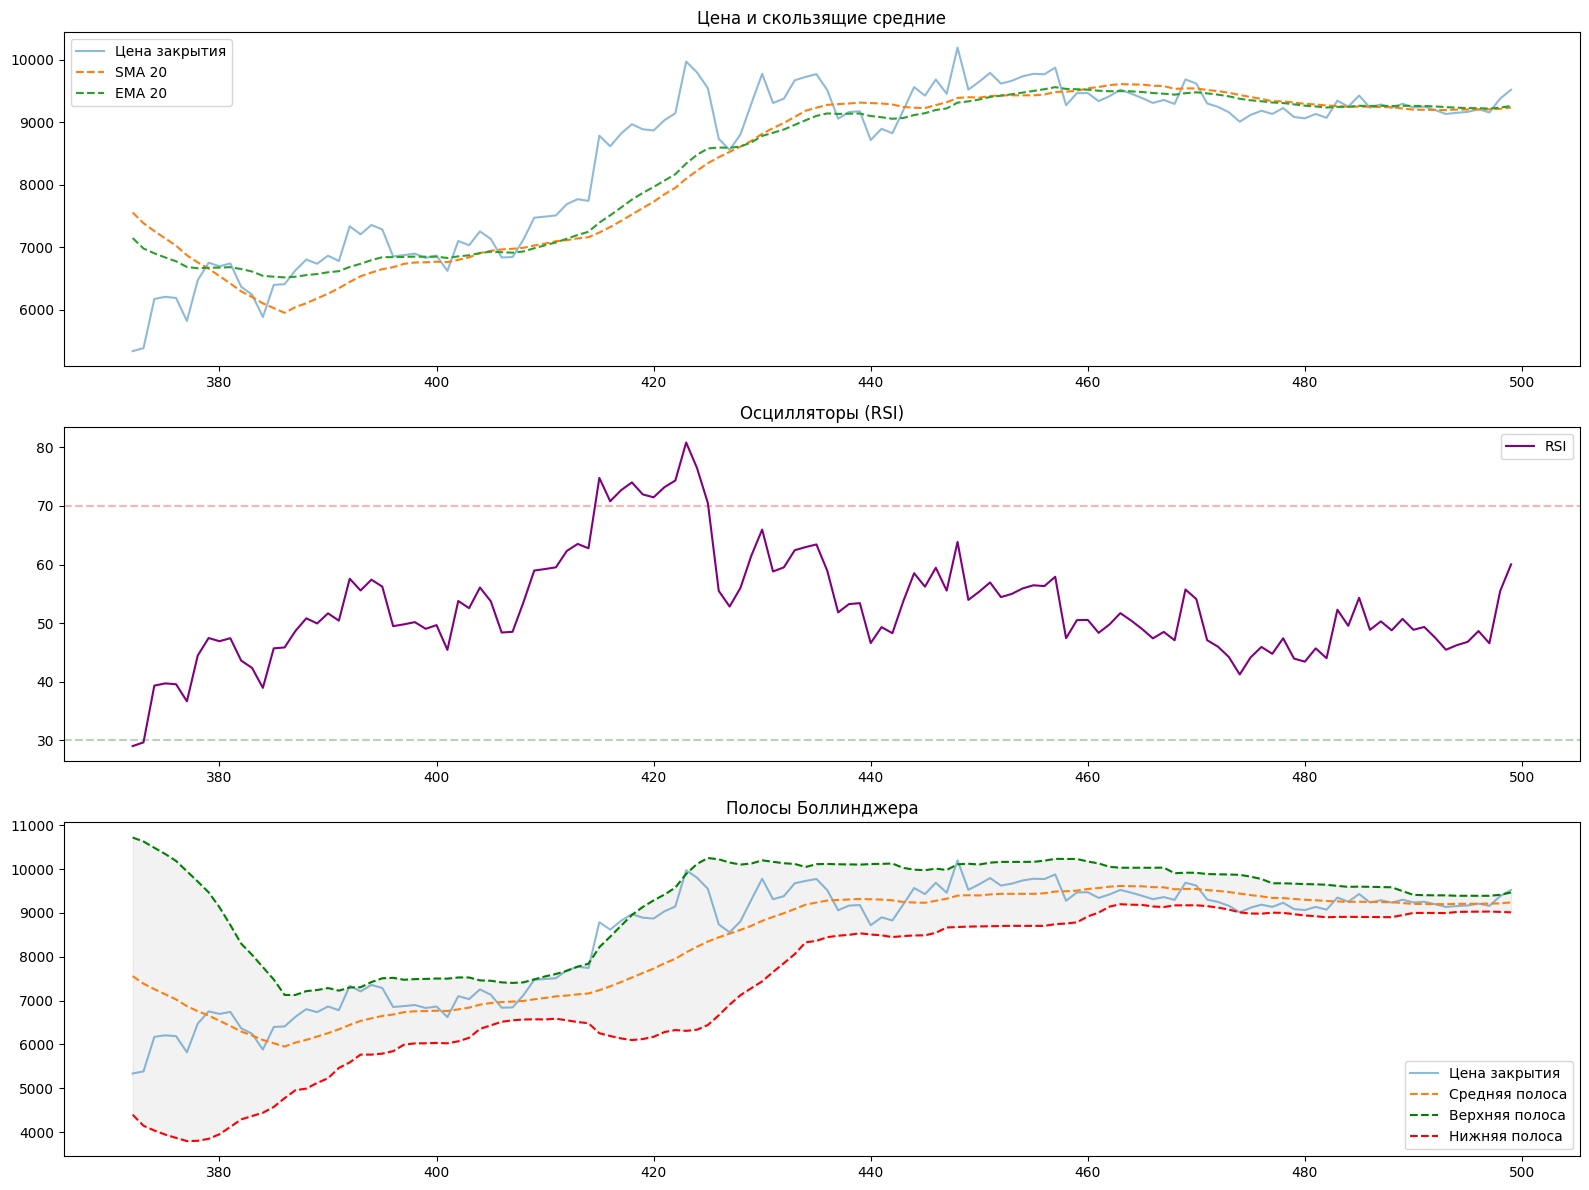

In [14]:
plot_feature_analysis(X, y)
# Получаем названия признаков до нормализации
feature_names = X.columns
# Вызываем функцию с передачей названий признаков
compare_models(models, X_train_scaled, X_test_scaled, y_train, y_test, feature_names)
plot_technical_indicators(df.iloc[split_idx:])  # только тестовые данные

<div class="alert alert-danger">

## Пишем выводы.
## Меняем целевую и проводим дополнительный анализ моделей!

--

### 7. Отправка сигналов на Bybit через Webhook


```python
import requests
from datetime import datetime

def send_webhook(symbol, side, qty, price, strategy_id="test123"):
    url = 'https://api.bybit.com/custom_webhook_endpoint'
    data = {
        "symbol": symbol,
        "side": side,
        "qty": str(qty),
        "price": str(price),
        "trigger_time": datetime.utcnow().isoformat(),
        "max_lag": "20",
        "strategy_id": strategy_id
    }
    response = requests.post(url, json=data)
    print(response.status_code, response.text)

# Пример сигнала
send_webhook("BTC/USDT", "buy", 1, df['close'].iloc[-1])
```


***Не ясно как это все дело будет работать***
Нужна консультация